# Busca com Metaheurísticas

Neste notebook apresentamos algumas soluções para o problema de roteamento em grafos utilizando algumas metaheurísticas. 

## Instância do problema
A seguir definimos um grafo com arestas ponderadas.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math

G = nx.Graph()
cities = ['A', 'B', 'C', 'D', 'E']
distances = {
    ('A', 'B'): 2, ('A', 'C'): 4, ('A', 'D'): 7, ('A', 'E'): 3,
    ('B', 'C'): 5, ('B', 'D'): 1, ('B', 'E'): 8,
    ('C', 'D'): 3, ('C', 'E'): 6,
    ('D', 'E'): 4,
}

G.add_nodes_from(cities)
G.add_weighted_edges_from([(a, b, distances[(a, b)]) for a, b in distances])

# Função para calcular o custo total de uma rota
def calculate_route_cost(route):
    total_cost = 0
    for i in range(len(route) - 1):
        d = distances.get((route[i], route[i + 1]), 0)
        if d == 0:
            d = distances.get((route[i + 1], route[i]), 0)
        total_cost += d
    return total_cost

## Simulated Annealing

In [2]:
def simulated_annealing(graph, initial_temperature, cooling_rate, number_of_iterations):
    current_solution = list(graph.nodes)
    random.shuffle(current_solution)
    current_cost = calculate_route_cost(current_solution)
    
    temperature = initial_temperature
    
    while temperature > 1:
        for _ in range(number_of_iterations):
            # Gera um vizinho por troca de duas cidades
            new_solution = current_solution.copy()
            i, j = random.sample(range(len(new_solution)), 2)
            new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
            new_cost = calculate_route_cost(new_solution)
            
            if new_cost < current_cost or random.random() < math.exp((current_cost - new_cost) / temperature):
                current_solution = new_solution
                current_cost = new_cost
        
        temperature *= cooling_rate

    return current_solution, current_cost


In [3]:
best_route, best_cost = simulated_annealing(G, 10000, 0.99, 100)
print("Melhor rota:", best_route)
print("Custo da melhor rota:", best_cost)

Melhor rota: ['E', 'A', 'B', 'D', 'C']
Custo da melhor rota: 9


In [4]:
# Função para visualizar o grafo
def plot_graph(graph, path=None, pos=None):
    if pos == None:
        pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph, pos)
    nx.draw_networkx_labels(graph, pos)
    nx.draw_networkx_edges(graph, pos, edge_color='gray')
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    
    if path:
        edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color='red', width=2)
        plt.title(f"Melhor Rota: {' -> '.join(path)}\nCusto: {calculate_route_cost(path)}")
    else:
        plt.title("Grafo das Cidades")

    plt.axis('off')
    plt.show()
    
    return pos

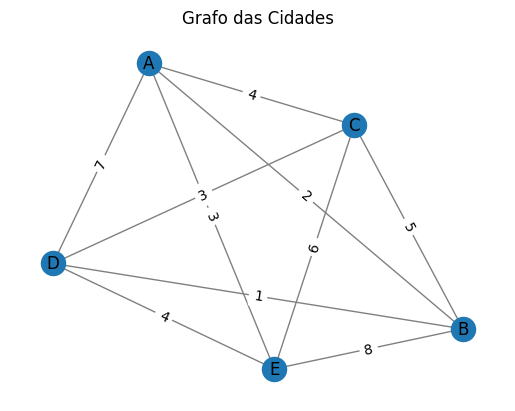

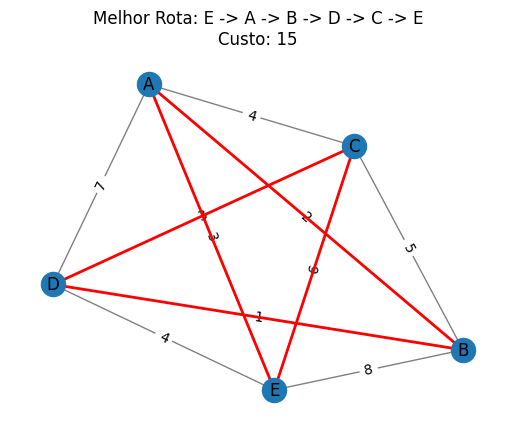

{'A': array([-0.533915  ,  0.71344959]),
 'B': array([ 0.99307441, -0.4239027 ]),
 'C': array([0.46466611, 0.44962612]),
 'D': array([-1.       , -0.1436643]),
 'E': array([ 0.07617448, -0.59550871])}

In [5]:
# Visualização do grafo inicial
pos = plot_graph(G)

# Visualização da melhor rota
plot_graph(G, best_route + [best_route[0]], pos=pos)

## Algoritmos Genéticos

In [6]:
import random

def create_initial_population(graph, population_size):
    """Gera uma população inicial de caminhos aleatórios."""
    population = []
    for _ in range(population_size):
        path = list(graph.nodes())
        random.shuffle(path)
        population.append(path)
    return population

def calculate_fitness(graph, path):
    """Calcula a aptidão de um caminho como o inverso do custo total."""
    cost = sum(graph[u][v]['weight'] for u, v in zip(path, path[1:]))
    return 1 / cost

def select_parents(population, fitness_scores, k=3):
    """Seleciona pais para reprodução usando o método do torneio."""
    parents = []
    for _ in range(2):
        tournament = random.sample(list(enumerate(fitness_scores)), k)
        winner = max(tournament, key=lambda item: item[1])
        parents.append(population[winner[0]])
    return parents

def crossover(parent1, parent2):
    """Realiza o crossover (cruzamento) entre dois pais para criar um filho."""
    cut = random.randint(1, len(parent1) - 2)
    child = parent1[:cut] + [node for node in parent2 if node not in parent1[:cut]]
    return child

def mutate(path, mutation_rate):
    """Realiza uma mutação em um caminho com uma dada taxa de mutação."""
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(path)), 2)
        path[i], path[j] = path[j], path[i]

def genetic_algorithm(graph, population_size=100, generations=1000, mutation_rate=0.01):
    population = create_initial_population(graph, population_size)
    
    for generation in range(generations):
        fitness_scores = [calculate_fitness(graph, path) for path in population]
        
        new_population = []
        for _ in range(population_size):
            parent1, parent2 = select_parents(population, fitness_scores)
            child = crossover(parent1, parent2)
            mutate(child, mutation_rate)
            new_population.append(child)
        
        population = new_population
    
    best_path = max(population, key=lambda path: calculate_fitness(graph, path))
    return best_path, 1 / calculate_fitness(graph, best_path)


In [7]:
# Executando o algoritmo genético
best_path, best_cost = genetic_algorithm(G)
print("Melhor rota:", best_route)
print("Custo da melhor rota:", best_cost)

Melhor rota: ['E', 'A', 'B', 'D', 'C']
Custo da melhor rota: 9.0


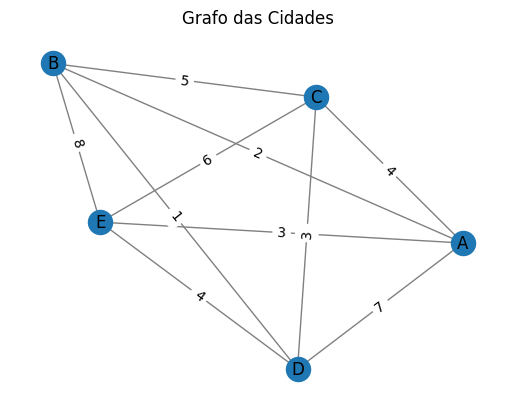

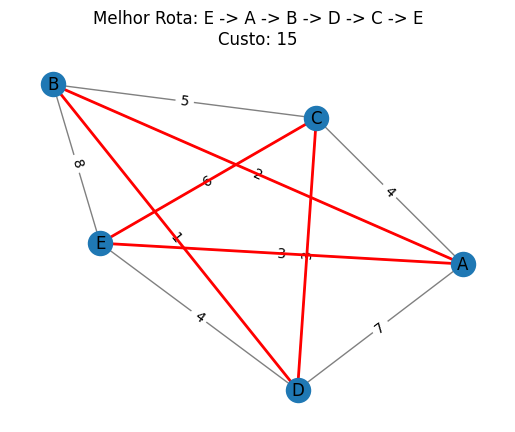

{'A': array([ 0.85269479, -0.25935923]),
 'B': array([-0.75847018,  0.79696549]),
 'C': array([0.27637776, 0.59893489]),
 'D': array([ 0.20247046, -1.        ]),
 'E': array([-0.57307282, -0.13654115])}

In [9]:
# Visualização do grafo inicial
pos = plot_graph(G)

# Visualização da melhor rota
plot_graph(G, best_path + [best_path[0]], pos=pos)